# **Milestone 1**

## **Problem Definition**
**The context:** malaria is a parasitic blood infection which kills hunderes of thousands of people annually, with children being the most vulnerable. Malaria infections can be identified in a lab, but this process takes time and is heavily dependent on the expertise of the laboratory technician.

**The objectives:** the goal is to create an automated process for distinguishing between healthy red blood cells and cells inficted by the malaria parasite. This can be accomplished through the creation of a deep learning model which takes images of red blood cells as its input and categorizes those images as either infected or uninfected.

**The key questions:** to create a deep learning model to distinguish between images, it will be necessary to understand the data which is being used. As the model will distinguish between infected and uninfected cells visually, it is necessary to know the characterisitcs of the images themselves, such as their size and the colors they contain. What's more, it will also be important to consider the resolution at which the images will be entered into the deep learning model. This model will be trained using Google Colab, and the platform only offers access to a limited amount of RAM. It may be necessary to reduce the resolution of the images being processed in order to not extend beyone the computational resources available on this platform.

**The problem formulation:** ultimately, this is a classification problem using computer vision. Neural networks are well suited to this sort of task, but it will be necessary to prepare the data ahead of time in order to ensure that the inputs are consistent. More traditional, artificial feed-forward neural networks may be sufficient for this task, however convolution neural networks are well suited to processing images as they better retain the spacial relationships between elements in the images themselves.


In [3]:
# mounting the drive in order to import the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Loading the data**


In [4]:
import zipfile # zipfile will allow us to extract the compressed images files stored in google drive

path = '/content/drive/MyDrive/Colab Notebooks/cell_images.zip' # the file path to where the compressed images files are being stored

# extracting the compressed images so they can be read into the notebook and processed
with zipfile.ZipFile(path, 'r') as zip_ref:
  zip_ref.extractall()

The data is divided between two files: one for the training data and one for the testing data. Each file has been divided between images of infected and uninfected red blood cells. 

In order to process this data, it will be necessary to read the images into the notebook and properly label them.

In [5]:
import os # this library will make it easier to manipulate file paths
import cv2 # this library will be necessary to read and manipulate the images

# the original images vary in size. What's more, loading every image into the notebook with their full resolution occupies a great deal of RAM.
# we can resize the images as we see fit, allowing both a consistent image size and more efficient utilization of limited RAM
IMG_SIZE = 50

# these are the file paths for train and test data
test_path = '/content/cell_images/test'
train_path = '/content/cell_images/train'

# both the train and test data are divided between parasitized and uninfected cases.
categories = ['parasitized', 'uninfected']

# these will be the lists in which our final outputs are stored
train_data = []
test_data = []

# here, we create two functions, one for creating our training data, and the other for creating our testing data
def create_train_data():
  # loads each images file individually
  for category in categories:
    path = os.path.join(train_path, category)
    class_num = category
    # reads the specified image, resizes it according to the specified IMG_SIZE, and appends it to the output list
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path, img))
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      train_data.append([new_array, class_num]) # saves the image array and label as a tuple to the train_data list

def create_test_data():
  # loads each images file individually
  for category in categories:
    path = os.path.join(test_path, category)
    class_num = category
    # reads the specified image, resizes it according to the specified IMG_SIZE, and appends it to the output list
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path, img))
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      test_data.append([new_array, class_num]) # saves the image array and label as a tuple to the test_data list

In [6]:
# calling these two functions will create our train and test data
create_train_data()
create_test_data()

Our data is now stored in two lists of tuples. The first element of each tuple contains a 50x50x3 array and the second element contains the label.

## **Data Exploration**

We've successfully loaded our train and test data and saved them to two separate lists. Each is a list of tuples, with the first element corresponding to the image array and the second element corresponding to the label of that image.

Next, we will explore the properties of our data and prepare them as inputs to the neural network models we will create later.

In [ ]:
# confirming the size of the train and test data
print(f'the length of the train data is {len(train_data)}')
print(f'the length of the test data is {len(test_data)}')

the length of the train data is 24958
the length of the test data is 2600


**observations:** we can see that we have 24958 cases in our training set and 2600 cases in our testing set, which are the numbers we were expecting. This shows that every case was successfully loaded into our notebook.

### **Visualizing the images**

In [7]:
# the numpy and pandas libraries will allow us to easily manipulate our data and arrays
import numpy as np 
import pandas as pd
# matplot lib and seaborn will help us visualize important characteristics of our data
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import load_img # this function will help us display images of individual cases

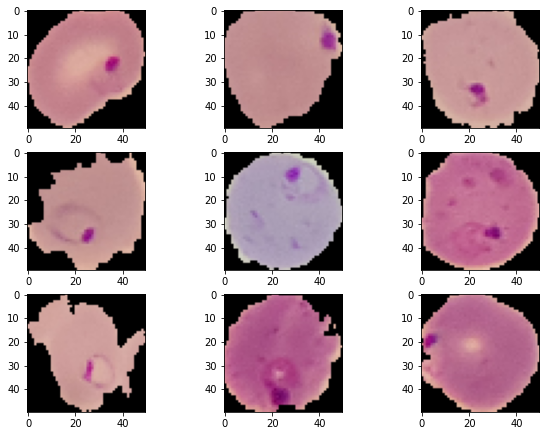

In [ ]:
# displaying infected cells 
cell_imgs = [fn for fn in os.listdir(f'{test_path}/{categories[0]}')]
select_cell = np.random.choice(cell_imgs, 9, replace=False)

fig = plt.figure(figsize= (10, 10))

for i in range(9):
  ax = fig.add_subplot(4, 3, i+1)
  fp = f'{test_path}/{categories[0]}/{select_cell[i]}'
  fn = load_img(fp, target_size=(IMG_SIZE, IMG_SIZE))
  plt.imshow(fn)

plt.show()

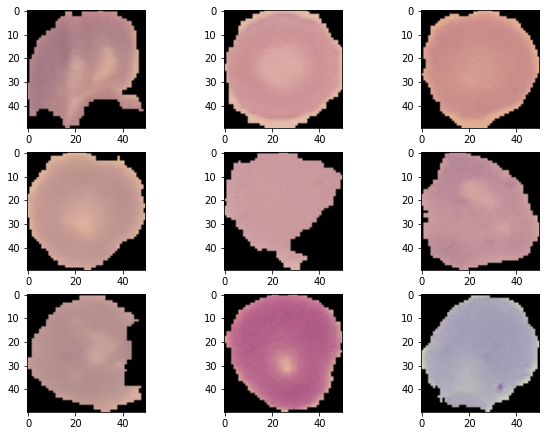

In [ ]:
# displaying uninfected cells 
cell_imgs = [fn for fn in os.listdir(f'{test_path}/{categories[1]}')]
select_cell = np.random.choice(cell_imgs, 9, replace=False)

fig = plt.figure(figsize= (10, 10))

for i in range(9):
  ax = fig.add_subplot(4, 3, i+1)
  fp = f'{test_path}/{categories[1]}/{select_cell[i]}'
  fn = load_img(fp, target_size=(IMG_SIZE, IMG_SIZE))
  plt.imshow(fn)

plt.show()

**observations:** above, we can see nine random images of infected cells and uninfected cells taken from out testing dataset. Each image is displayed at a 50x50 resolution.

From a cursory lookover, there are obvious distinguishing features between the infected and uninfected cases, which lends confidence to the idea of automating the identification process.

In [8]:
# separating features and labels of the train and test sets
X_train = []
y_train = []

# np.random.shuffle(train_data) # shuffles the dataset to ensure parasitized and uninfected cases are mixed
for feature, label in train_data:
  X_train.append(feature)
  y_train.append(label)

X_test = []
y_test = []

# np.random.shuffle(test_data) # shuffles the dataset to ensure parasitized and uninfected cases are mixed
for feature, label in test_data:
  X_test.append(feature)
  y_test.append(label)

In [ ]:
# checking the minimum and maximum pixel values in the training set
train_min = 0
train_max = 0
test_min = 0
test_max = 0
for x in X_train:
  if x.min() < train_min:
    train_min = x.min()
  if x.max() > train_max:
    train_max = x.max()
for x in X_test:
  if x.min() < test_min:
    test_min = x.min()
  if x.max() > test_max:
    test_max = x.max()

print(f'train min: {train_min}, test min: {test_min}, train max: {train_max}, test max: {test_max}')

train min: 0, test min: 0, train max: 255, test max: 255


**observations:** The above code shows us that all pixel values in the dataset range between 0 and 255. As such, to normalize the dataset simply involves dividing each element of each array by 255

In [9]:
# converting the features into numpy arrays and normalizing them
X_train = np.array(X_train) 
X_test = np.array(X_test) 
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# dividing the training feature sett into infected and uninfected cases
infected_cases = X_train[0: 12581]
uninfected_cases = X_train[12582:]

In [ ]:
def mean_img(array, title):
  # finding mean of the numpy arrays
  mean_img = np.mean(array, axis=0)
  # displaying the matrix as an image
  plt.imshow(mean_img)
  plt.title(f'average of {title}')
  plt.axis('off')
  plt.show()

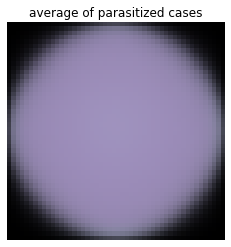

In [ ]:
# finding the mean image of parasitized images
mean_img(infected_cases, 'parasitized cases')

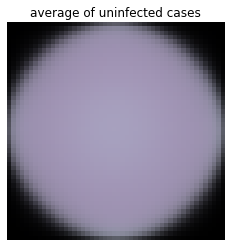

In [ ]:
# finding the mean image of uninfeced images
mean_img(uninfected_cases, 'uninfected cases')

**observations:** averaging the images for the infected and uninfected images hasn't resulted in any meaningful insights. 

In [10]:
# converting labels into DataFrames and encoding them
y_train = pd.DataFrame(y_train, columns=['Label'], dtype='object')
y_test = pd.DataFrame(y_test, columns=['Label'], dtype='object')

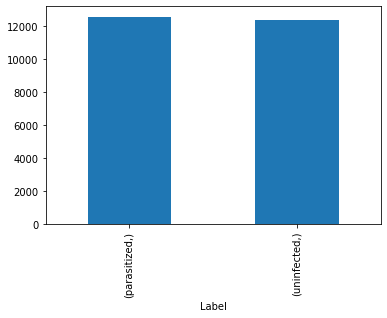

In [ ]:
# finding the number of parasitized and uninfected cases in our training data
y_train.value_counts().plot(kind='bar')

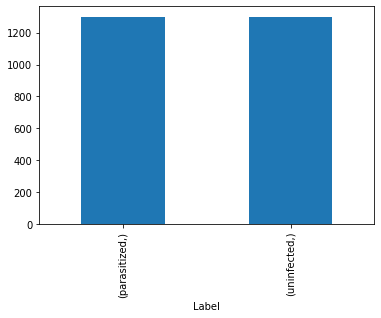

In [ ]:
# find the number of parasitizied and uninfected cases in our testing data
y_test.value_counts().plot(kind='bar')

**observations:** we can see above that the number of infected and uninfected cases in our training set are nearly equal, with a count of 12582 and 12376 respectively. Likewise, the number of infected and uninfected cases in our testing set are exactly equal, with each having 1300 cases.

Having roughly equal numbers of infected and uninfected cases is helpful, as it saves us from having to implement a bias in our final model.

## **Converting RBG to HSV**

In [ ]:
X_train_hsv = []

for x in X_train:
  X_train_hsv.append(cv2.cvtColor(x, cv2.COLOR_BGR2HSV))

X_test_hsv = []

for x in X_test:
  X_test_hsv.append(cv2.cvtColor(x, cv2.COLOR_BGR2HSV))

error: ignored

In [ ]:
# comparing RGB to HSV images
rand = np.random.randint(0, 24958)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[rand])
ax1.set_title('RGB'+f' {y_train[rand]}')
ax2.imshow(X_train_hsv[rand])
ax2.set_title('HSV'+f' {y_train[rand]}')
plt.show()

**observations: **HSV can be a useful way to store color information for use in computer vision. More information is retained in HSV, as slight variations in saturation or value may cause major numerical differences when expressed as RGB.

## **Applying Gaussian Blur**

In [ ]:
# applying gaussian blur to the training and test datasets
X_train_gbx = []

for x in X_train:
  X_train_gbx.append(cv2.GaussianBlur(x, (5, 5), 0))

X_test_gbx = []

for x in X_test:
  X_test_gbx.append(cv2.GaussianBlur(x, (5, 5), 0))

In [ ]:
# comparing blurred and unblurred images
rand = np.random.randint(0, 24958)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[rand])
ax1.set_title('Unblurred'+f' {y_train[rand]}')
ax2.imshow(X_train_gbx[rand])
ax2.set_title('Blurred'+f' {y_train[rand]}')
plt.show()

**observations:** gaussian blur can be useful to remove noise from an image, which can help ensure a neural network does not overfit the training data.

In [11]:
# encoding the labels as dummy variables
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

## **Proposed Approach**

**potential techniques:** neural networks are an ideal solution for this kind of classificaion problem. Several different architectures are available to building a network capable of classifiying these images. An artificail neural network could work. This technique would require us to turn each array into a vector in order to be fed through the network. Convolutional neural networks may be a better choice, as they allow us to retain the spacial relationships between features within the images themselves. Alternatively, it may be possible to build a graph neural network to accomplish the same task, treating each pixel as a node and each adjacent pixel as its neighbors.

**overall solution design:** the goal will be to build several different neural networks with different architectures in order to find the model which best fits the test dataset. Addtionally, the input data can be processed in several different way, any of which may impact the final results (i.e. applying gaussian blur, converting images to HSV, etc). 

**measures of success:** the best measure for our model's success will be its ultimate recall score. As this model is being built to aid in a clinical diagnostic setting, reducing the number of false negatives output by the model is of chief importance. As such, other measures such as accuracy and precision are less important, even if it results in the model outputting more false positive.

# **Milestone 2**

We've separated our dataset into its featues (the image arrays which will be the inputs of our neural networks) and our labels (parasitized vs uninfected). Our training data has been normalized and several transformations can be used to possibly improve model performances (i.e. converting to HSV and applying gaussian blur). Addtionally, our labels have been one-hot encoded.

Now we can begin to build neural network models and testing their performance, focusing chiefly on their recall scores.

In [12]:
# Libraries relvant to neural network building
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model # Sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten # Importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU, Activation
from tensorflow.keras import backend 
from tensorflow.keras.optimizers import Adam, SGD # Optimizers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  # Regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses, optimizers

In [13]:
# clearing the backend to maximize RAM efficiency
from tensorflow.keras import backend
backend.clear_session()

## **Building an Artificial Neural Network**

We'll begin by building an artificial neural network, which will consist an input layer, one or more fully connected layers, and an output layer with two nodes corresponding to our two possible classifications (parasitized and uninfected).

In [14]:
# flattening the arrays in the training data in order to feed them into our ANN
X_train_flat = []
for x in X_train:
  X_train_flat.append(x.flatten())
X_train_flat = np.array(X_train_flat)
X_test_flat = []
for x in X_test:
  X_test_flat.append(x.flatten())
X_test_flat = np.array(X_test_flat)

In [15]:
# Building the artificial neural network
model1 = Sequential()

# the model will consists of three fully connected layers
model1.add(Dense(64, activation='relu', input_shape=(7500,))) # the input layer
model1.add(Dense(32, activation='relu')) # the hidden layer
model1.add(Dense(2, activation='sigmoid')) # the output layer

opt = SGD(learning_rate=0.01, momentum=0.9) # the optimizer includes various hyperparameters to adjust how the model learns
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                480064    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 482,210
Trainable params: 482,210
Non-trainable params: 0
_________________________________________________________________


In [17]:
# training the the ANN model
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history1 = model1.fit(X_train_flat,
                    y_train,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/30
311/312 [============================>.] - ETA: 0s - loss: 0.6393 - accuracy: 0.6416
Epoch 1: val_accuracy improved from -inf to 0.11579, saving model to best_model.h5
312/312 [==============================] - 4s 6ms/step - loss: 0.6393 - accuracy: 0.6416 - val_loss: 1.1160 - val_accuracy: 0.1158
Epoch 2/30
303/312 [============================>.] - ETA: 0s - loss: 0.6206 - accuracy: 0.6566
Epoch 2: val_accuracy improved from 0.11579 to 0.42588, saving model to best_model.h5
312/312 [==============================] - 1s 5ms/step - loss: 0.6200 - accuracy: 0.6575 - val_loss: 0.8680 - val_accuracy: 0.4259
Epoch 3/30
300/312 [===========================>..] - ETA: 0s - loss: 0.5989 - accuracy: 0.6834
Epoch 3: val_accuracy did not improve from 0.42588
312/312 [==============================] - 1s 4ms/step - loss: 0.5996 - accuracy: 0.6831 - val_loss: 1.0033 - val_accuracy: 0.2424
Epoch 4/30
302/312 [============================>.] - ETA: 0s - loss: 0.5919 - accuracy: 0.6902
Epo

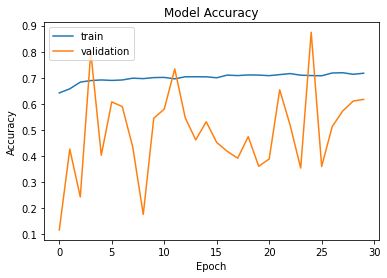

In [18]:
# plotting the history of the loss function
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**observations:** after thirty epochs, the model is not producing accurate results. While the accuracy on the training set about 0.7, the accuracy on the validation set is fluctuating wildly. This suggests that the model is severely overfitting the training set. As such it is unlikely the model will perform well on the testing data set.

              precision    recall  f1-score   support

           0       0.63      0.69      0.66      1300
           1       0.66      0.59      0.62      1300

    accuracy                           0.64      2600
   macro avg       0.64      0.64      0.64      2600
weighted avg       0.64      0.64      0.64      2600



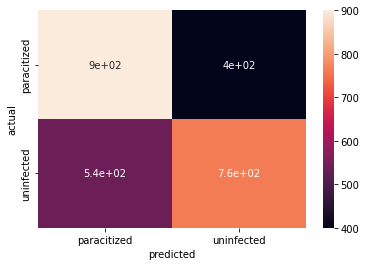

In [19]:
# plotting the confusion matrix 
from sklearn.metrics import classification_report, confusion_matrix

pred = model1.predict(X_test_flat)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(np.array(y_test), axis=1)

print(classification_report(y_true, pred))


cm = confusion_matrix(y_true, pred)
sns.heatmap(cm, annot=True, xticklabels=['paracitized', 'uninfected'], yticklabels=['paracitized', 'uninfected'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

**observations:** the confusion matrix shows that the model's overall performance isn't very good. While this model could certaintly be improved, an artifical neural network is likely not the ideal choice for this specific problem. Instead, a convolutional neural network would be better suited to the task, as these kinds of neural networks better retain spatial relationships within the image.

In [20]:
# saving model1 as 'ANN1.h5'
model1.save('ANN1.h5')

In [21]:
# deleting variables to save on memory
del X_train_flat, X_test_flat, model1, history1

## **Building a Convolutional Neural Network**

In [22]:
# clearing the backend to free up memory
backend.clear_session()

In [23]:
# Building a CNN model
model2 = Sequential()

# building the convolutional layers
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model2.add(MaxPooling2D((2, 2), padding='same'))
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), padding='same'))

model2.add(Flatten()) # flattening the output of the convolutional layers in order to be interpreted by the fully connected layers

# building the fully connected layers
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))

opt = SGD(learning_rate=0.01, momentum=0.9)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                3

In [25]:
# training the model
mc = ModelCheckpoint('best_model2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history2 = model2.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/30
308/312 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9389
Epoch 1: val_accuracy improved from -inf to 0.95633, saving model to best_model2.h5
312/312 [==============================] - 3s 11ms/step - loss: 0.1646 - accuracy: 0.9393 - val_loss: 0.1578 - val_accuracy: 0.9563
Epoch 2/30
306/312 [============================>.] - ETA: 0s - loss: 0.1254 - accuracy: 0.9540
Epoch 2: val_accuracy improved from 0.95633 to 0.96334, saving model to best_model2.h5
312/312 [==============================] - 3s 9ms/step - loss: 0.1247 - accuracy: 0.9543 - val_loss: 0.1195 - val_accuracy: 0.9633
Epoch 3/30
308/312 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.9608
Epoch 3: val_accuracy improved from 0.96334 to 0.98858, saving model to best_model2.h5
312/312 [==============================] - 3s 10ms/step - loss: 0.1114 - accuracy: 0.9610 - val_loss: 0.0797 - val_accuracy: 0.9886
Epoch 4/30
312/312 [==============================] - ETA: 

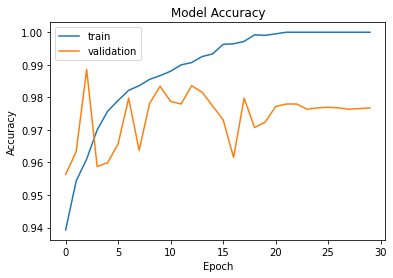

In [26]:
# plotting the history
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**observations:** we can see the performance of the CNN model is much better than our initial ANN model. The training set reached an accuracy of 100%, but the accuracy of the validation set fluctuated around 0.97 or so. This suggests that our model may be  overfitting our training data. Implementing dropout on a new CNN may improve performance.

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1300
           1       0.98      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



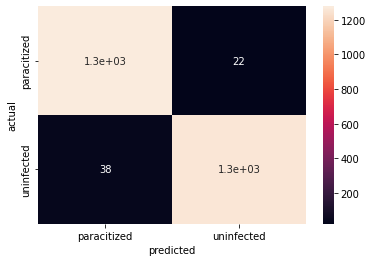

In [27]:
# plotting the confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

pred = model2.predict(X_test)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(np.array(y_test), axis=1)

print(classification_report(y_true, pred))


cm = confusion_matrix(y_true, pred)
sns.heatmap(cm, annot=True, xticklabels=['paracitized', 'uninfected'], yticklabels=['paracitized', 'uninfected'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

**observations:** from the confusion matrix, we can see that the model is peforming quite well. The model's accuracy, precision, and recall scores are all around 98%, meaning the model is predicting correctly far more often than it is incorrect. However, a recall score of 98% may still be too low in a clincal diagnostic setting, as these results suggest that 2% of people infected with malaria would be misdiagnosed. As such, it is still necessary to improve the model.

We can begin to improve the model by adding transformtions to our input, such as applying gaussian blur and converting the images to HSV

In [28]:
# saving model2 as 'CNN1.h5'
model2.save('CNN1.h5')

In [29]:
# clearing the backend to free up memory
backend.clear_session()

In [30]:
import random

# Creating transformed data sets
# separating features and labels of the train and test sets
X_train2 = []
y_train2 = []

random.shuffle(train_data) # shuffles the dataset to ensure parasitized and uninfected cases are mixed
for feature, label in train_data:
  X_train2.append(feature)
  y_train2.append(label)

X_test2 = []
y_test2 = []

random.shuffle(test_data) # shuffles the dataset to ensure parasitized and uninfected cases are mixed
for feature, label in test_data:
  X_test2.append(feature)
  y_test2.append(label)


# converting labels into DataFrames and encoding them
y_train2 = pd.DataFrame(y_train2, columns=['Label'], dtype='object')
y_test2 = pd.DataFrame(y_test2, columns=['Label'], dtype='object')

# encoding the labels as dummy variables
y_train2 = pd.get_dummies(y_train2)
y_test2 = pd.get_dummies(y_test2)

In [53]:
# converting images to HSV format
X_train_hsv = []

for x in X_train2:
  X_train_hsv.append(cv2.cvtColor(x, cv2.COLOR_BGR2HSV))

X_test_hsv = []

for x in X_test2:
  X_test_hsv.append(cv2.cvtColor(x, cv2.COLOR_BGR2HSV))

  

In [32]:
# applying gaussian blur to the RGB images
X_train_gbx = []

for x in X_train2:
  X_train_gbx.append(cv2.GaussianBlur(x, (5, 5), 0))

X_test_gbx = []

for x in X_test2:
  X_test_gbx.append(cv2.GaussianBlur(x, (5, 5), 0))

In [54]:
# applying gaussian blur to the HSV images
X_train_hsvgbx = []

for x in X_train_hsv:
  X_train_hsvgbx.append(cv2.GaussianBlur(x, (5, 5), 0))

X_test_hsvgbx = []

for x in X_test_hsv:
  X_test_hsvgbx.append(cv2.GaussianBlur(x, (5, 5), 0))

In [34]:
# normailizng the HSV images
X_train_hsv = np.array(X_train_hsv) / 255.0
X_test_hsv = np.array(X_test_hsv) / 255.0

In [35]:
# normalizing the blurred images
# the maximum value of the arrays after applying gaussian blur is 250, so we will divide by 250 to normalize the arrays
X_train_gbx = np.array(X_train_gbx)/250
X_test_gbx = np.array(X_test_gbx)/250

In [55]:
# normalizing the HSV + gaussian blur datasets
X_train_hsvgbx = np.array(X_train_hsvgbx) / 255
X_test_hsvgbx = np.array(X_test_hsvgbx) / 255

### Training the model using HSV image data

In [39]:
# training the model
mc = ModelCheckpoint('best_model2_hsv.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history2_hsv = model2.fit(X_train_hsv,
                    y_train2,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/30
307/312 [============================>.] - ETA: 0s - loss: 0.3239 - accuracy: 0.8549
Epoch 1: val_accuracy improved from -inf to 0.96074, saving model to best_model2_hsv.h5
312/312 [==============================] - 3s 11ms/step - loss: 0.3207 - accuracy: 0.8565 - val_loss: 0.1091 - val_accuracy: 0.9607
Epoch 2/30
311/312 [============================>.] - ETA: 0s - loss: 0.0897 - accuracy: 0.9707
Epoch 2: val_accuracy improved from 0.96074 to 0.96715, saving model to best_model2_hsv.h5
312/312 [==============================] - 3s 11ms/step - loss: 0.0899 - accuracy: 0.9707 - val_loss: 0.0973 - val_accuracy: 0.9671
Epoch 3/30
312/312 [==============================] - ETA: 0s - loss: 0.0698 - accuracy: 0.9768
Epoch 3: val_accuracy improved from 0.96715 to 0.97296, saving model to best_model2_hsv.h5
312/312 [==============================] - 3s 10ms/step - loss: 0.0698 - accuracy: 0.9768 - val_loss: 0.0842 - val_accuracy: 0.9730
Epoch 4/30
312/312 [==========================

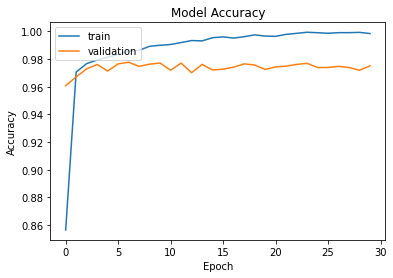

In [40]:
# plotting the history
plt.plot(history2_hsv.history['accuracy'])
plt.plot(history2_hsv.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



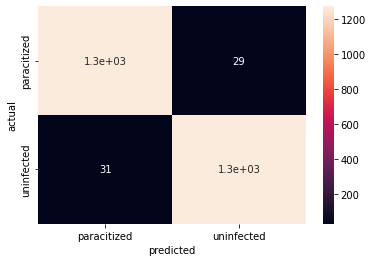

In [42]:
# printing the confusion matrix for model2_hsv
pred = model2.predict(X_test_hsv)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(np.array(y_test2), axis=1)

print(classification_report(y_true, pred))


cm = confusion_matrix(y_true, pred)
sns.heatmap(cm, annot=True, xticklabels=['paracitized', 'uninfected'], yticklabels=['paracitized', 'uninfected'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

**observations:** converting the images to HSV format hasn't appeared to significantly effected the performance of the model. Accuracy, precision, and recall remain around 0.98. Next we can apply gaussian blur to see if that has a significant impact.

In [43]:
del X_train_hsv

In [46]:
# clearing the backend to save memory
backend.clear_session()

### Training the model using blurred images

In [47]:
mc = ModelCheckpoint('best_model2_gbx.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history2_gbx = model2.fit(X_train_gbx,
                    y_train2,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/30
308/312 [============================>.] - ETA: 0s - loss: 0.9435 - accuracy: 0.5886
Epoch 1: val_accuracy improved from -inf to 0.72676, saving model to best_model2_gbx.h5
312/312 [==============================] - 4s 11ms/step - loss: 0.9382 - accuracy: 0.5905 - val_loss: 0.5382 - val_accuracy: 0.7268
Epoch 2/30
309/312 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9331
Epoch 2: val_accuracy improved from 0.72676 to 0.95513, saving model to best_model2_gbx.h5
312/312 [==============================] - 3s 10ms/step - loss: 0.1808 - accuracy: 0.9331 - val_loss: 0.1172 - val_accuracy: 0.9551
Epoch 3/30
308/312 [============================>.] - ETA: 0s - loss: 0.1054 - accuracy: 0.9634
Epoch 3: val_accuracy improved from 0.95513 to 0.95553, saving model to best_model2_gbx.h5
312/312 [==============================] - 3s 10ms/step - loss: 0.1055 - accuracy: 0.9633 - val_loss: 0.1127 - val_accuracy: 0.9555
Epoch 4/30
310/312 [==========================

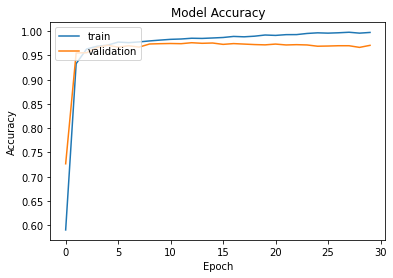

In [48]:
# plotting the history
plt.plot(history2_gbx.history['accuracy'])
plt.plot(history2_gbx.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1300
           1       0.98      0.97      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



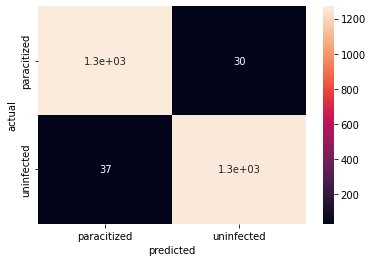

In [50]:
# printing the confusion matrix for the blurred images
pred = model2.predict(X_test_gbx)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(np.array(y_test2), axis=1)

print(classification_report(y_true, pred))


cm = confusion_matrix(y_true, pred)
sns.heatmap(cm, annot=True, xticklabels=['paracitized', 'uninfected'], yticklabels=['paracitized', 'uninfected'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

**observations:** applying gaussian blur to the images has not had a significant impact on the model's performance. It seems like our model is still overfitting the data. Applying gaussian blur should have helped with overfitting in principle, as smoothing out the images helps ensure the model doesn't become confused by random noise. However, it doesn't seem to have made an impact.

We can run the CNN training one more after both converting the images to HSV and applying gaussian blur to see if the model improves at all.

In [52]:
del X_train_gbx
# clearing the backend to save memory
backend.clear_session()

### Training the model using HSV and Gaussian Blur

In [56]:
# training the model
mc = ModelCheckpoint('best_model_hsvgbx.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history2_hsvgbx = model2.fit(X_train_hsvgbx,
                    y_train2,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/30
311/312 [============================>.] - ETA: 0s - loss: 0.7875 - accuracy: 0.5014
Epoch 1: val_accuracy improved from -inf to 0.52023, saving model to best_model_hsvgbx.h5
312/312 [==============================] - 3s 11ms/step - loss: 0.7872 - accuracy: 0.5011 - val_loss: 0.6924 - val_accuracy: 0.5202
Epoch 2/30
307/312 [============================>.] - ETA: 0s - loss: 0.7015 - accuracy: 0.4897
Epoch 2: val_accuracy did not improve from 0.52023
312/312 [==============================] - 3s 10ms/step - loss: 0.7015 - accuracy: 0.4890 - val_loss: 0.6970 - val_accuracy: 0.4800
Epoch 3/30
310/312 [============================>.] - ETA: 0s - loss: 0.6980 - accuracy: 0.5053
Epoch 3: val_accuracy did not improve from 0.52023
312/312 [==============================] - 3s 10ms/step - loss: 0.6979 - accuracy: 0.5059 - val_loss: 0.6936 - val_accuracy: 0.5200
Epoch 4/30
310/312 [============================>.] - ETA: 0s - loss: 0.6974 - accuracy: 0.4993
Epoch 4: val_accuracy did no

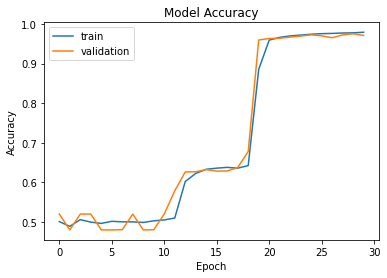

In [57]:
# plotting the history
plt.plot(history2_hsvgbx.history['accuracy'])
plt.plot(history2_hsvgbx.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1300
           1       0.97      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



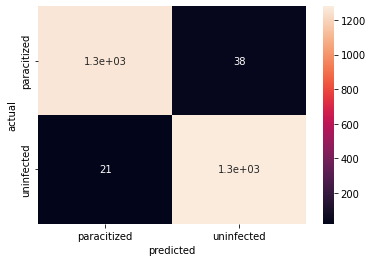

In [59]:
# print the confusion matrix for the hsv+gbx model
pred = model2.predict(X_test_hsvgbx)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(np.array(y_test2), axis=1)

print(classification_report(y_true, pred))


cm = confusion_matrix(y_true, pred)
sns.heatmap(cm, annot=True, xticklabels=['paracitized', 'uninfected'], yticklabels=['paracitized', 'uninfected'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

**observations:** converting the images to HSV and gaussian blur hasn't resulted in a significant improvement in the model's improvement. Manipulating the images hasn't resulted in significant gains in model performance. 

It may prove more effective to focus on making improvements to the architecture of the neural network itself.

In [82]:
# clearing the backend to save memory
backend.clear_session()

## **Creating an Improved CNN**

batch normalization can improve the perforamnce of the model by normalizing the output of each layer before feeding them as inputs to the next layer. This algorithm can increase learning speed and reduces the model's sensitivity to the weight initialization

In [60]:
# Building a CNN model with batch normalization
model3 = Sequential()

# building the convolutional layers
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model3.add(MaxPooling2D((2, 2), padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D((2, 2), padding='same'))
model3.add(BatchNormalization())

model3.add(Flatten()) # flattening the output of the convolutional layers in order to be interpreted by the fully connected layers

# building the fully connected layers
model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(32, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(2, activation='sigmoid'))

opt = SGD(learning_rate=0.01, momentum=0.9)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                        

In [61]:
mc = ModelCheckpoint('best_model3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history3 = model3.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/30
309/312 [============================>.] - ETA: 0s - loss: 0.4571 - accuracy: 0.7829
Epoch 1: val_accuracy improved from -inf to 0.99980, saving model to best_model3.h5
312/312 [==============================] - 5s 12ms/step - loss: 0.4552 - accuracy: 0.7840 - val_loss: 0.0011 - val_accuracy: 0.9998
Epoch 2/30
309/312 [============================>.] - ETA: 0s - loss: 0.2056 - accuracy: 0.9240
Epoch 2: val_accuracy did not improve from 0.99980
312/312 [==============================] - 3s 10ms/step - loss: 0.2051 - accuracy: 0.9241 - val_loss: 0.8307 - val_accuracy: 0.5859
Epoch 3/30
308/312 [============================>.] - ETA: 0s - loss: 0.1348 - accuracy: 0.9509
Epoch 3: val_accuracy did not improve from 0.99980
312/312 [==============================] - 3s 10ms/step - loss: 0.1346 - accuracy: 0.9511 - val_loss: 0.0666 - val_accuracy: 0.9972
Epoch 4/30
307/312 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9613
Epoch 4: val_accuracy did not impr

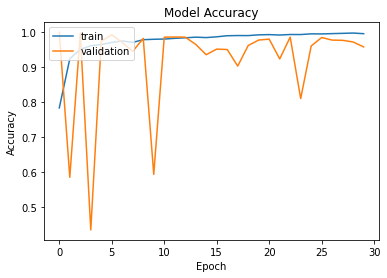

In [62]:
# plotting the history
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1300
           1       0.99      0.95      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



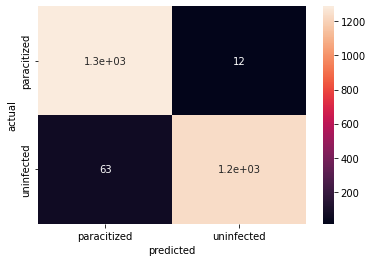

In [63]:
# print the confusion matrix for model 3
from sklearn.metrics import classification_report, confusion_matrix
pred = model3.predict(X_test)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(np.array(y_test), axis=1)

print(classification_report(y_true, pred))


cm = confusion_matrix(y_true, pred)
sns.heatmap(cm, annot=True, xticklabels=['paracitized', 'uninfected'], yticklabels=['paracitized', 'uninfected'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

**observations:** batch normalizaion has improved the model's recall slightly, pushing it past the 0.99 point. Of the 1300 parasitized cases in our testing set, the model misclassified only 12. 

This is the best performing model thus far. It is possible that training with the hsvgbx data set may also demonstrate improved performance


In [64]:
# saving the model
model3.save('CNN2.h5')

In [65]:
# clearing backend
backend.clear_session()

In [66]:
# training with the hsvgbx dataset
mc = ModelCheckpoint('best_model3_hsvgbx.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history3_hsvgbx = model3.fit(X_train_hsvgbx,
                    y_train2,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/30
309/312 [============================>.] - ETA: 0s - loss: 0.2236 - accuracy: 0.9238
Epoch 1: val_accuracy improved from -inf to 0.83774, saving model to best_model3_hsvgbx.h5
312/312 [==============================] - 4s 12ms/step - loss: 0.2224 - accuracy: 0.9242 - val_loss: 0.3436 - val_accuracy: 0.8377
Epoch 2/30
307/312 [============================>.] - ETA: 0s - loss: 0.1069 - accuracy: 0.9650
Epoch 2: val_accuracy improved from 0.83774 to 0.96354, saving model to best_model3_hsvgbx.h5
312/312 [==============================] - 3s 10ms/step - loss: 0.1065 - accuracy: 0.9650 - val_loss: 0.1002 - val_accuracy: 0.9635
Epoch 3/30
311/312 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9692
Epoch 3: val_accuracy improved from 0.96354 to 0.96775, saving model to best_model3_hsvgbx.h5
312/312 [==============================] - 3s 11ms/step - loss: 0.0905 - accuracy: 0.9692 - val_loss: 0.1026 - val_accuracy: 0.9677
Epoch 4/30
308/312 [=================

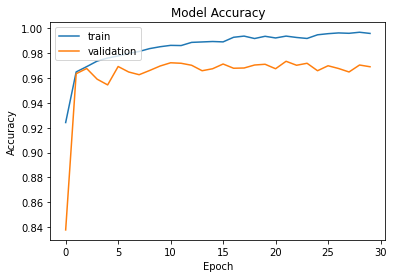

In [67]:
# plotting the history
plt.plot(history3_hsvgbx.history['accuracy'])
plt.plot(history3_hsvgbx.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



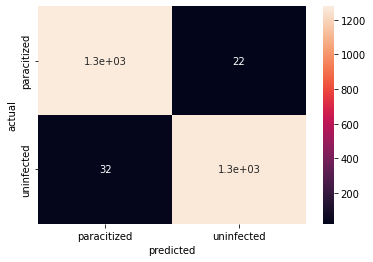

In [70]:
# print the confusion matrix for model 3
from sklearn.metrics import classification_report, confusion_matrix
pred = model3.predict(X_test_hsvgbx)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(np.array(y_test2), axis=1)

print(classification_report(y_true, pred))


cm = confusion_matrix(y_true, pred)
sns.heatmap(cm, annot=True, xticklabels=['paracitized', 'uninfected'], yticklabels=['paracitized', 'uninfected'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

**observations:** training with the hsvgbx data set hasn't improved performance.

In [71]:
# saving the model
model3.save('CNN2_hsvgbx')

## **Using a Pre-Trained Model**

pre-trained models may prove to be helpful, as they save us the trouble of training an entire model from scratch.

In [72]:
# clearing the backend
backend.clear_session()

In [73]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(50, 50, 3)) 

vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                              

In [75]:
transfer_layer = vgg.get_layer('block5_pool')

vgg.trainable = False

# Add classification layers on top of it  
x = Flatten()(transfer_layer.output)  # Flatten the output from the 3rd block of the VGG16 model

x = Dense(256, activation = 'relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons
x = BatchNormalization()(x)

pred = Dense(2, activation = 'softmax')(x)

model4 = Model(vgg.input, pred) # Initializing the model

opt = SGD(learning_rate=0.01, momentum=0.9)
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [76]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history4 = model4.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/30
312/312 [==============================] - ETA: 0s - loss: 0.3645 - accuracy: 0.8332
Epoch 1: val_accuracy improved from -inf to 0.66246, saving model to best_model.h5
312/312 [==============================] - 12s 35ms/step - loss: 0.3645 - accuracy: 0.8332 - val_loss: 0.6589 - val_accuracy: 0.6625
Epoch 2/30
311/312 [============================>.] - ETA: 0s - loss: 0.3297 - accuracy: 0.8529
Epoch 2: val_accuracy did not improve from 0.66246
312/312 [==============================] - 9s 29ms/step - loss: 0.3295 - accuracy: 0.8530 - val_loss: 1.3811 - val_accuracy: 0.0691
Epoch 3/30
310/312 [============================>.] - ETA: 0s - loss: 0.3259 - accuracy: 0.8567
Epoch 3: val_accuracy improved from 0.66246 to 0.99559, saving model to best_model.h5
312/312 [==============================] - 9s 30ms/step - loss: 0.3261 - accuracy: 0.8566 - val_loss: 0.0212 - val_accuracy: 0.9956
Epoch 4/30
311/312 [============================>.] - ETA: 0s - loss: 0.3148 - accuracy: 0.8635

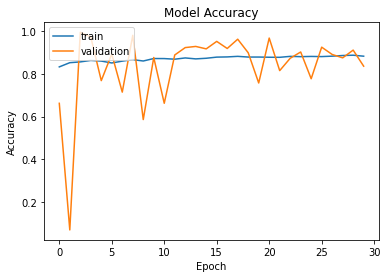

In [77]:
# plotting the history
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1300
           1       0.93      0.78      0.85      1300

    accuracy                           0.86      2600
   macro avg       0.87      0.86      0.86      2600
weighted avg       0.87      0.86      0.86      2600



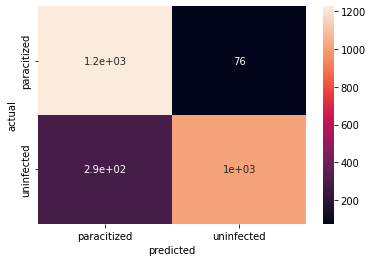

In [78]:
# print the confusion matrix for model 4
from sklearn.metrics import classification_report, confusion_matrix
pred = model4.predict(X_test)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(np.array(y_test), axis=1)

print(classification_report(y_true, pred))


cm = confusion_matrix(y_true, pred)
sns.heatmap(cm, annot=True, xticklabels=['paracitized', 'uninfected'], yticklabels=['paracitized', 'uninfected'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

**observations:** using a pretrained model hasn't resulted in improved performance. In fact, this pre-trained model is significanlty worse than the two convolutional neural networks we built previously. 

Looking at the history of the loss function, it seems that the training accuracy and validation accuracy were not significantly improving over time. It may be the case that the model is stuck within a local optimum, which it may find its way out of with sufficient time. However, from these initial results it seems safe to assume it would be more time and computational efficient to focus on making improvements to the model elsewhere

In [79]:
# saving the model
model4.save('CNN3.h5')

In [80]:
# clearing backend
backend.clear_session()

## **Making a Final CNN**

For a last effort at improving the performance of a CNN model, we'll create one last model incorporating all the improvements we've discussed thus far. We'll create a more complex network using the augmented data we used in previous models. We'll also use batch normalization and dropout to, hopefully, reduce overfitting. Addtionally, we'll also lower the learning rate and increase the number of epochs used to train the model, helping the alogrithm navigate the loss function to arive at a global minimum

In [81]:
# Building a CNN model with batch normalization
model5 = Sequential()

# building the convolutional layers
model5.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model5.add(MaxPooling2D((2, 2), padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D((2, 2), padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D((2, 2), padding='same'))
model5.add(BatchNormalization())

model5.add(Flatten()) # flattening the output of the convolutional layers in order to be interpreted by the fully connected layers

# building the fully connected layers
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.2))
model5.add(BatchNormalization())
model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.2))
model5.add(BatchNormalization())
model5.add(Dense(16, activation='relu'))
model5.add(Dropout(0.2))
model5.add(BatchNormalization())
model5.add(Dense(2, activation='sigmoid'))

opt = SGD(learning_rate=0.001, momentum=0.9)
model5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                        

In [82]:
# training the model
mc = ModelCheckpoint('best_model5.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history5 = model5.fit(X_train,
                    y_train,
                    epochs=60,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/60
624/624 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.6398
Epoch 1: val_accuracy improved from -inf to 0.98758, saving model to best_model5.h5
624/624 [==============================] - 9s 12ms/step - loss: 0.6816 - accuracy: 0.6398 - val_loss: 0.1280 - val_accuracy: 0.9876
Epoch 2/60
619/624 [============================>.] - ETA: 0s - loss: 0.4349 - accuracy: 0.8009
Epoch 2: val_accuracy improved from 0.98758 to 0.99399, saving model to best_model5.h5
624/624 [==============================] - 7s 11ms/step - loss: 0.4335 - accuracy: 0.8018 - val_loss: 0.0314 - val_accuracy: 0.9940
Epoch 3/60
622/624 [============================>.] - ETA: 0s - loss: 0.2302 - accuracy: 0.9145
Epoch 3: val_accuracy did not improve from 0.99399
624/624 [==============================] - 7s 11ms/step - loss: 0.2297 - accuracy: 0.9148 - val_loss: 0.1560 - val_accuracy: 0.9529
Epoch 4/60
620/624 [============================>.] - ETA: 0s - loss: 0.1823 - accuracy: 0.936

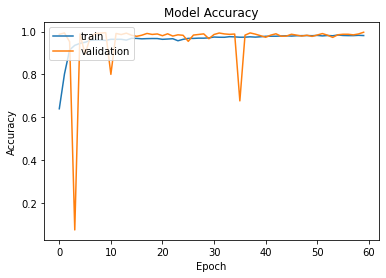

In [83]:
# plotting the history
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1300
           1       0.95      0.99      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



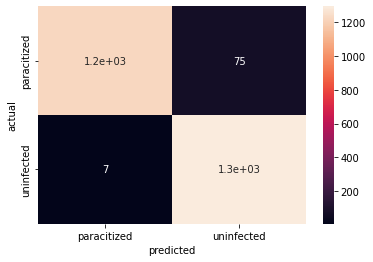

In [85]:
# print the confusion matrix for model 5
from sklearn.metrics import classification_report, confusion_matrix
pred = model5.predict(X_test)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(np.array(y_test), axis=1)

print(classification_report(y_true, pred))


cm = confusion_matrix(y_true, pred)
sns.heatmap(cm, annot=True, xticklabels=['paracitized', 'uninfected'], yticklabels=['paracitized', 'uninfected'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

**observations:** the increased complexity of the model still has not resulted in significant improvements. Of the 1300 cases of parasitized red blood cells, 75 were incorrectly categorized as uninfected.

We can try to train this model using the hsvgbx data set to see if it results in better performance.

In [86]:
# training the model
mc = ModelCheckpoint('best_model5_hsvgbx.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history5_hsvgbx = model5.fit(X_train_hsvgbx,
                    y_train2,
                    epochs=60,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[mc])

Epoch 1/60
621/624 [============================>.] - ETA: 0s - loss: 0.2385 - accuracy: 0.9293
Epoch 1: val_accuracy improved from -inf to 0.96915, saving model to best_model5_hsvgbx.h5
624/624 [==============================] - 7s 11ms/step - loss: 0.2377 - accuracy: 0.9296 - val_loss: 0.0916 - val_accuracy: 0.9692
Epoch 2/60
619/624 [============================>.] - ETA: 0s - loss: 0.1152 - accuracy: 0.9621
Epoch 2: val_accuracy did not improve from 0.96915
624/624 [==============================] - 7s 11ms/step - loss: 0.1149 - accuracy: 0.9621 - val_loss: 0.0935 - val_accuracy: 0.9671
Epoch 3/60
624/624 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9671
Epoch 3: val_accuracy improved from 0.96915 to 0.97436, saving model to best_model5_hsvgbx.h5
624/624 [==============================] - 7s 11ms/step - loss: 0.1070 - accuracy: 0.9671 - val_loss: 0.0790 - val_accuracy: 0.9744
Epoch 4/60
622/624 [============================>.] - ETA: 0s - loss: 0.1005 - a

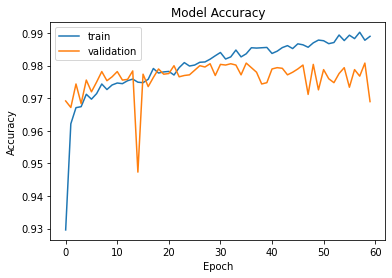

In [87]:
# plotting the history
plt.plot(history5_hsvgbx.history['accuracy'])
plt.plot(history5_hsvgbx.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.96      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



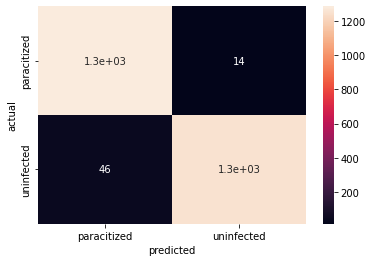

In [88]:
# print the confusion matrix for model 5
from sklearn.metrics import classification_report, confusion_matrix
pred = model5.predict(X_test_hsvgbx)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(np.array(y_test2), axis=1)

print(classification_report(y_true, pred))


cm = confusion_matrix(y_true, pred)
sns.heatmap(cm, annot=True, xticklabels=['paracitized', 'uninfected'], yticklabels=['paracitized', 'uninfected'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

**observations:** training the more complex CNN on the hsvgbx data set has resulted in a moderate improvement to performance. Only 14 of the 1300 paracitized cases have been misclassified.

# **Final Desgin Proposal**

## **Final Observations**
We have tested several different model architectures, using several different transformations of the same image data set. 

The worst performing model was our artificial neural network, which had a recall score of only 0.69, meaning it misclassified over 30% of paracitized cases.

The second worst performing model was our model using a pre-trained network, with a recall of 0.94.

We created several convolutional neural network, all of which had comparable performance of 0.98 or more. Our best performing model was model 3, which was the first to incorporate batch normalization. A close second was our most complicated model, model 5 trained on the HSV formatted and Gaussian blurred images. Model 3 only misclassfied 12 of 1300 paracitized images, whereas model 5 miscalssfied 14.

## **Final Suggestions**

Given performance of the various models, it seems that model 3, a convolution neural network incorporating batch normalization is the best choice. With a recall score over 0.99, the model will correctly identify malaria 99% of the time. 

For a task with clinical significance such as malaria identification, a recall score of 0.99 may not be high enough. However, the recall score of this model must be compared with the recall score of the actual medical professional currently performing the task.